In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt


In [2]:
project_dir = "../"
data_dir = "/home/nikhil/projects/brain_changes/data/ukbb/"

freesurfer_csv = f"{data_dir}imaging/freesurfer/ukb47552_followup_subset.csv"

train_csv = f"{project_dir}metadata/metadata_train.csv"
test_csv = f"{project_dir}metadata/metadata_test.csv"

freesurfer_fields = f"{project_dir}/metadata/ukbb_freesurfer_fields.txt"



In [3]:
freesurfer_fields_df = pd.read_csv(freesurfer_fields,sep="	")
freesurfer_fields_df["phenotype"] = freesurfer_fields_df["Description"].str.split(" ",1,expand=True)[0]
freesurfer_fields_df["phenotype"] = freesurfer_fields_df["phenotype"].replace({"Mean":"Mean Thickness"})
CT_fields = freesurfer_fields_df[freesurfer_fields_df["phenotype"]=="Mean Thickness"]["Field ID"]
volume_fields = freesurfer_fields_df[freesurfer_fields_df["phenotype"]=="Volume"]["Field ID"]

print(f"number of CT fields: {len(CT_fields)}, volume fields: {len(volume_fields)}")

number of CT fields: 62, volume fields: 62


In [4]:
pheno_fields = CT_fields # + volume_fields
pheno_cols_ses2 = list(pheno_fields.astype(str) + "-2.0")
pheno_cols_ses3 = list(pheno_fields.astype(str) + "-3.0")
usecols = ["eid"] + pheno_cols_ses2 + pheno_cols_ses3

print(f"reading {len(usecols)} columes")

freesurfer_df = pd.read_csv(freesurfer_csv, usecols=usecols)

# Remove eids with missing 2nd or 3rd ses data
eid_missing_data = freesurfer_df[freesurfer_df.isna().any(axis=1)]["eid"].values
print(f"number participants missing 2nd or 3rd ses freesurfer data: {len(eid_missing_data)}")

freesurfer_df = freesurfer_df[~freesurfer_df["eid"].isin(eid_missing_data)]
freesurfer_eids = freesurfer_df["eid"].values

print(f"available freesurfer subjects: {len(freesurfer_eids)}")

freesurfer_df.head()

reading 125 columes
number participants missing 2nd or 3rd ses freesurfer data: 63
available freesurfer subjects: 3237


,eid,27174-2.0,27174-3.0,27175-2.0,27175-3.0,27176-2.0,27176-3.0,27177-2.0,27177-3.0,27178-2.0,...,27293-2.0,27293-3.0,27294-2.0,27294-3.0,27295-2.0,27295-3.0,27296-2.0,27296-3.0,27297-2.0,27297-3.0
0,1000635,2.786,2.874,2.910,2.852,2.275,2.307,3.389,3.379,2.836,...,2.387,2.435,2.967,2.958,2.707,2.628,2.229,2.142,2.875,2.750
1,1008391,3.191,2.875,3.080,3.037,2.273,2.143,3.004,2.571,2.846,...,2.588,2.592,3.073,2.859,2.839,2.770,3.086,3.322,3.255,3.003
2,1010129,2.329,1.870,2.836,2.798,1.995,1.943,3.302,3.193,2.812,...,2.376,2.395,3.081,3.086,2.993,2.945,3.016,3.032,3.193,3.168
3,1010994,2.785,2.581,2.671,2.603,2.060,1.819,3.144,3.225,2.793,...,2.513,2.416,2.919,2.881,2.654,2.581,2.088,2.161,2.912,2.866
4,1013774,2.963,3.191,2.617,2.856,2.035,2.050,2.751,3.385,2.830,...,2.274,2.403,3.041,3.008,2.635,2.737,2.527,2.696,2.983,3.263


In [5]:
train_df = pd.read_csv(train_csv)
train_eids = train_df["eid"]
train_eids_avail = set(train_eids) & set(freesurfer_eids)
train_df = pd.merge(train_df, freesurfer_df, on="eid", how="inner")

test_df = pd.read_csv(test_csv)
test_eids = test_df["eid"]
test_eids_avail = set(test_eids) & set(freesurfer_eids)
test_df = pd.merge(test_df, freesurfer_df, on="eid", how="inner")

print(f"train samples: {len(train_eids)}, freesurfer data available: {len(train_eids_avail)}, overlap: {len(train_df)}")
print(f"test samples: {len(test_eids)}, freesurfer data available: {len(test_eids_avail)}, overlap: {len(test_df)}")

train samples: 2145, freesurfer data available: 1909, overlap: 1909
test samples: 1057, freesurfer data available: 958, overlap: 958


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
    
class UKBB_ROI_Dataset_simple(Dataset):
    ''' UKBB ROI Dataset comprsing FreeSurfer output
    '''

    def __init__(self, data_df, pheno_cols, transform=None):
        self.data_df = data_df 
        self.pheno_cols = pheno_cols
        self.transform = transform
        
    def __len__(self):
        n_samples = len(self.data_df)
        return n_samples

    def __getitem__(self, idx):
        _df = self.data_df.copy()
        eid = _df.loc[idx,"eid"]
        age_ses2 = _df[_df["eid"]==eid]["age_at_ses2"].values[0]   
        
        X_baseline = _df[_df["eid"]==eid][self.pheno_cols].values

        y_baseline = age_ses2/100
        y_baseline = np.expand_dims(y_baseline,0)

        input_tensor = torch.tensor(X_baseline,dtype=torch.float32)
        output_tensor = torch.tensor(y_baseline,dtype=torch.float32)

        return eid, input_tensor, output_tensor


class UKBB_ROI_Dataset(Dataset):
    ''' UKBB ROI Dataset comprsing FreeSurfer output
    '''

    def __init__(self, data_df, pheno_cols_ses2, pheno_cols_ses3, transform=None):
        self.data_df = data_df 
        self.pheno_cols_ses2 = pheno_cols_ses2
        self.pheno_cols_ses3 = pheno_cols_ses3
        self.transform = transform
        
    def __len__(self):
        n_samples = len(self.data_df)
        return n_samples

    def __getitem__(self, idx):
        _df = self.data_df.copy()
        eid = _df.loc[idx,"eid"]
        age_ses2 = _df[_df["eid"]==eid]["age_at_ses2"].values[0]
        age_ses3 = _df[_df["eid"]==eid]["age_at_ses3"].values[0]    
        
        X_baseline = _df[_df["eid"]==eid][self.pheno_cols_ses2].values
        X_followup = _df[_df["eid"]==eid][self.pheno_cols_ses3].values

        # input1 = np.expand_dims(input1,0)
        # input2 = np.expand_dims(input2,0)

        y_baseline = age_ses2/100
        y_followup = age_ses3/100
        y_baseline = np.expand_dims(y_baseline,0)
        y_followup = np.expand_dims(y_followup,0)

        input_tensor = (torch.tensor(X_baseline,dtype=torch.float32), torch.tensor(X_followup,dtype=torch.float32))
        output_tensor = (torch.tensor(y_baseline,dtype=torch.float32), torch.tensor(y_followup,dtype=torch.float32))

        return eid, input_tensor, output_tensor


class simple_FF(nn.Module):
    def __init__(self, input_size,hidden_size,output_size=1):
        super(simple_FF, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        # self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
    
        self.fcOut = nn.Linear(self.hidden_size, output_size)

        # self.relu = nn.ReLU()


    def forward(self, x1):
        # lower twin branches
        x1 =  self.fc1(x1)
        # x1 =  self.fc2(x1)
    
        xout = self.fcOut(x1)
    
        return xout

# Toy network for testing siamese arch
class LSN_FF(nn.Module):
    def __init__(self, input_size,hidden_size,output_size=1):
        super(LSN_FF, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(2*self.hidden_size, self.hidden_size) #concat
        self.fc4 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc5 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc6 = nn.Linear(self.hidden_size, self.hidden_size)

        self.drop = nn.Dropout(p=0.2)
    
        self.fcOut = nn.Linear(self.hidden_size, output_size)

        # self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()


    def forward(self, x1, x2):
        # print(f"x1 shape: {x1.shape}, x2 shape: {x2.shape}")

        # lower twin branches
        x1 = self.fc1(x1)
        x2 = self.fc1(x2)

        x = torch.cat([x1,x2],dim=2)
        
        # print(f"concat shape: {x.shape}")
        x = self.fc3(x)
        
        # predict (don't want sigmoid!)
        x3 = self.fcOut(x)
        x4 = self.fcOut(x)
    
        x_out = torch.cat([x3,x4],dim=2)

        return x_out

def train(model, train_dataloader, optimizer, criterion, n_epochs):
    batch_loss_list = []
    epoch_loss_list = []
    preds_df = pd.DataFrame()
    # model.train()

    for epoch in range(n_epochs):
        running_loss = 0.0
    
        print("Starting epoch " + str(epoch+1))    
            
        batch_idx = 0
        for eids, inputs, outputs in train_dataloader:
            img1 = inputs
    
            age_at_ses2 = outputs
            img1 = img1.to(device)
        
            age_at_ses2 = age_at_ses2.to(device)
                        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            preds = model(img1)
            
            p_df = pd.DataFrame()
            p_df["eid"] = eids
            p_df["pred_baseline"] = np.vstack(preds.detach().numpy())
            p_df["epoch"] = epoch
            p_df["batch_idx"] = batch_idx
            
            preds_df = preds_df.append(p_df)
            
            loss = criterion(preds[:,:,0],age_at_ses2)
            # loss = twinLoss(preds[:,:,0], preds[:,:,1], age_at_ses2, age_at_ses3, criterion) 
            
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            batch_loss_list.append(loss.item())
            # print(f"running loss: {running_loss}")
            batch_idx = batch_idx + 1
        
        
        epoch_loss = running_loss/len(train_dataloader)
        epoch_loss_list.append(epoch_loss)
        print(f"epoch {epoch} loss: {epoch_loss:5.4f}")

    print(f"epoch {epoch} loss: {epoch_loss:5.4f}")

    ## loss df
    batch_loss_df = pd.DataFrame()
    batch_loss_df["batch_loss"] = batch_loss_list

    epoch_loss_df = pd.DataFrame()
    epoch_loss_df["epoch_loss"] = epoch_loss_list

    return model, batch_loss_df, epoch_loss_df, preds_df


def train_simple(model, train_df, pheno_cols_ses2, optimizer, criterion, n_epochs):
    batch_loss_list = []
    epoch_loss_list = []
    preds_df = pd.DataFrame()
    # model.train()

    for epoch in range(n_epochs):
        running_loss = 0.0
    
        print("Starting epoch " + str(epoch+1))    

        n_samples = len(train_df)
            
        batch_idx = 0
        for i in range(n_samples):
            eids = train_df.loc[i,"eid"]
            img1 = train_df.loc[i,pheno_cols_ses2].values.astype(np.float32)            
            age_at_ses2 = train_df.loc[i,"age_at_ses2"] / 100

            img1 = torch.tensor(img1,dtype=torch.float32)
            age_at_ses2 = torch.tensor(age_at_ses2,dtype=torch.float32)

            img1 = img1.to(device)
            age_at_ses2 = age_at_ses2.to(device)
                        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            preds = model(img1)
                        
            loss = criterion(preds,age_at_ses2)
            # loss = twinLoss(preds[:,:,0], preds[:,:,1], age_at_ses2, age_at_ses3, criterion) 
            
            loss.backward()
            optimizer.step()

            p_df = pd.DataFrame()
            p_df["eid"] = eids
            p_df["pred_baseline"] = 100*np.squeeze(np.vstack(preds.detach().numpy()))
            p_df["epoch"] = epoch
            p_df["batch_idx"] = batch_idx
            
            preds_df = preds_df.append(p_df)
            # print statistics
            running_loss += loss.item()
            batch_loss_list.append(loss.item())
            # print(f"running loss: {running_loss}")
            batch_idx = batch_idx + 1
                
        epoch_loss = running_loss/n_samples
        epoch_loss_list.append(epoch_loss)
        print(f"epoch {epoch} loss: {epoch_loss:5.4f}")

    print(f"epoch {epoch} loss: {epoch_loss:5.4f}")

    ## loss df
    batch_loss_df = pd.DataFrame()
    batch_loss_df["batch_loss"] = batch_loss_list

    epoch_loss_df = pd.DataFrame()
    epoch_loss_df["epoch_loss"] = epoch_loss_list

    return model, batch_loss_df, epoch_loss_df, preds_df


def train_simple_LSN(model, train_df, pheno_cols_ses2,pheno_cols_ses3, optimizer, criterion, n_epochs):
    batch_loss_list = []
    epoch_loss_list = []
    preds_df = pd.DataFrame()
    # model.train()

    for epoch in range(n_epochs):
        running_loss = 0.0
    
        print("Starting epoch " + str(epoch+1))    

        n_samples = len(train_df)
            
        batch_idx = 0
        for i in range(n_samples):
            eids = train_df.loc[i,"eid"]
            img1 = train_df.loc[i,pheno_cols_ses2].values.astype(np.float32)   
            img1 = np.expand_dims(img1,0)
            img1 = np.expand_dims(img1,1)  
            age_at_ses2 = train_df.loc[i,"age_at_ses2"] / 100
            age_at_ses2 = np.expand_dims(age_at_ses2,axis=0)
            

            img2 = train_df.loc[i,pheno_cols_ses3].values.astype(np.float32)   
            img2 = np.expand_dims(img2,0)
            img2 = np.expand_dims(img2,1)         
            age_at_ses3 = train_df.loc[i,"age_at_ses3"] / 100
            age_at_ses3 = np.expand_dims(age_at_ses3,axis=0)

            img1 = torch.tensor(img1,dtype=torch.float32).to(device)
            age_at_ses2 = torch.tensor(age_at_ses2,dtype=torch.float32).to(device)    

            img2 = torch.tensor(img2,dtype=torch.float32).to(device)
            age_at_ses3 = torch.tensor(age_at_ses3,dtype=torch.float32).to(device)
            
            # print(f"shapes: {img1.shape}, {img2.shape}, {age_at_ses2.shape}, {age_at_ses3.shape}")
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            preds = model(img1,img2)
                        
            loss = twinLoss(preds[:,:,0], preds[:,:,1], age_at_ses2, age_at_ses3, criterion) 
            
            loss.backward()
            optimizer.step()

            p_df = pd.DataFrame()
            p_df["eid"] = eids
            p_df["pred_baseline"] = 100*np.squeeze(np.vstack(preds[:,:,0].detach().numpy()))
            p_df["pred_followup"] = 100*np.squeeze(np.vstack(preds[:,:,1].detach().numpy()))
            p_df["epoch"] = epoch
            p_df["batch_idx"] = batch_idx
            
            preds_df = preds_df.append(p_df)
            # print statistics
            running_loss += loss.item()
            batch_loss_list.append(loss.item())
            # print(f"running loss: {running_loss}")
            batch_idx = batch_idx + 1
        
        
        epoch_loss = running_loss/n_samples
        epoch_loss_list.append(epoch_loss)
        print(f"epoch {epoch} loss: {epoch_loss:5.4f}")

    print(f"epoch {epoch} loss: {epoch_loss:5.4f}")

    ## loss df
    batch_loss_df = pd.DataFrame()
    batch_loss_df["batch_loss"] = batch_loss_list

    epoch_loss_df = pd.DataFrame()
    epoch_loss_df["epoch_loss"] = epoch_loss_list

    return model, batch_loss_df, epoch_loss_df, preds_df

def twinLoss(x1,x2,y1,y2,loss_func):
    """Returns twin loss for a given loss func
    """
    loss1 = loss_func(x1,y1)
    loss2 = loss_func(x2,y2)
    loss = 0.5*(loss1 + loss2)
    return loss

def test_simple(model, test_dataloader, criterion=nn.L1Loss()):
    model.eval()
    with torch.no_grad():
        eid_list = []
        loss1_list = []
        y_pred_list = []
        y_test_list = []
        for eid, inputs, outputs in test_dataloader:
            eid_list.append(eid.detach().numpy())
            img1 = inputs
            age_at_ses2 = 100*outputs 
            y_test = age_at_ses2
            y_test_list.append(y_test)
            img1 = img1.to(device)
            age_at_ses2 = age_at_ses2.to(device) 
            
            preds = 100*model(img1) #Scale age
            y_pred_list.append(preds.detach().numpy())

            loss1 = criterion(preds[:,:,0],age_at_ses2)            
            loss1_list.append(loss1.item())

    return eid_list, y_test_list, y_pred_list, 
    
def test(model, test_dataloader, criterion=nn.L1Loss()):
    model.eval()
    with torch.no_grad():
        eid_list = []
        loss1_list = []
        loss2_list = []
        y_pred_list = []
        y_test_list = []
        for eid, inputs, outputs in test_dataloader:
            eid_list.append(eid.detach().numpy())
            img1 = inputs[0]
            img2 = inputs[1]

            age_at_ses2 = 100*outputs[0] 
            age_at_ses3 = 100*outputs[1] 

            y_test = (age_at_ses2,age_at_ses3)
            y_test_list.append(y_test)

            img1 = img1.to(device)
            img2 = img2.to(device)
            age_at_ses2 = age_at_ses2.to(device) 
            age_at_ses3 = age_at_ses3.to(device) 
            
            preds = 100*model(img1, img2) #Scale age
            y_pred_list.append(preds.detach().numpy())

            loss1 = criterion(preds[:,:,0],age_at_ses2)
            loss2 = criterion(preds[:,:,1],age_at_ses3)
            
            loss1_list.append(loss1.item())
            loss2_list.append(loss2.item())

    return eid_list, y_test_list, y_pred_list, loss1_list, loss2_list


In [7]:
# n_samples = 50

batch_size = 10
transform = None #"random_swap" #only for training

train_dataset = UKBB_ROI_Dataset_simple(train_df, pheno_cols_ses2, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# iter(train_dataloader).next()
print(f"len train dataset: {len(train_dataset)}")

len train dataset: 1909


In [8]:
n_epochs = 10
input_size = len(pheno_cols_ses2)
hidden_size = 10
lr = 0.001

model = LSN_FF(input_size,hidden_size=hidden_size)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=lr) #optim.SGD(model.parameters(), lr=lr, momentum=0.5)                                                                                               
criterion = nn.MSELoss()  #nn.L1Loss() #

# using subset of train dataloader for debug
# model, batch_loss_df, epoch_loss_df, preds_df = train(model,train_dataloader,optimizer,criterion,n_epochs)
# model, batch_loss_df, epoch_loss_df, preds_df = train_simple(model,train_df,pheno_cols_ses2,optimizer,criterion,n_epochs)
model, batch_loss_df, epoch_loss_df, preds_df = train_simple_LSN(model,train_df,pheno_cols_ses2,pheno_cols_ses3,optimizer,criterion,n_epochs)

Starting epoch 1


/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 loss: 0.0090
Starting epoch 2
epoch 1 loss: 0.0062
Starting epoch 3
epoch 2 loss: 0.0061
Starting epoch 4
epoch 3 loss: 0.0062
Starting epoch 5
epoch 4 loss: 0.0062
Starting epoch 6
epoch 5 loss: 0.0062
Starting epoch 7
epoch 6 loss: 0.0066
Starting epoch 8
epoch 7 loss: 0.0065
Starting epoch 9
epoch 8 loss: 0.0064
Starting epoch 10
epoch 9 loss: 0.0067
epoch 9 loss: 0.0067


,epoch_loss
0,0.009035
1,0.006195
2,0.006143
3,0.006166
4,0.006242


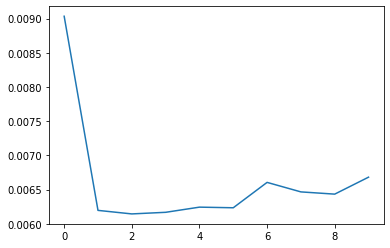

In [9]:
plt.plot(epoch_loss_df)
epoch_loss_df.head()

## LSN Test

In [10]:

test_dataset = UKBB_ROI_Dataset(test_df, pheno_cols_ses2,pheno_cols_ses3, transform=None)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


eid_list, y_test_list, y_pred_list, test_loss1, test_loss2 = test(model, test_dataloader)
y_test = np.squeeze(np.vstack(y_test_list))
y_pred = np.squeeze(np.vstack(y_pred_list))

test_r1 = stats.pearsonr(y_pred[:,0],y_test[:,0])[0]
test_r2 = stats.pearsonr(y_pred[:,1],y_test[:,1])[0]

test_age_1 = y_test[:,0]
test_age_2 = y_test[:,1]

test_brainage_1 = y_pred[:,0]
test_brainage_2 = y_pred[:,1]

df = pd.DataFrame()
df["eid"] = eid_list
df["test_age_1"] = test_age_1
df["test_age_2"] = test_age_2
df["test_brainage_1"] = test_brainage_1
df["test_brainage_2"] = test_brainage_2
df["test_loss1"] = test_loss1
df["test_loss2"] = test_loss2
df["test_r1"] = test_r1
df["test_r2"] = test_r2

test_loss = 0.5*(df["test_loss1"].mean() + df["test_loss2"].mean())
test_mae = 0.5*(np.mean(np.sqrt(df["test_loss1"].values)) + np.mean(np.sqrt(df["test_loss2"].values)))
print(f"test_loss: {test_loss}, test_mae: {test_mae}")

df

test_loss: 6.18095756124604, test_mae: 2.3214909432539432


,eid,test_age_1,test_age_2,test_brainage_1,test_brainage_2,test_loss1,test_loss2,test_r1,test_r2
0,[4071544],66.0,68.000000,64.663628,64.663628,1.336372,3.336372,0.313603,0.308775
1,[6005293],61.0,63.000000,65.026764,65.026764,4.026764,2.026764,0.313603,0.308775
2,[5739520],61.0,63.000000,64.494644,64.494644,3.494644,1.494644,0.313603,0.308775
3,[1308382],51.0,52.999996,64.753036,64.753036,13.753036,11.753040,0.313603,0.308775
4,[2991501],58.0,60.000004,64.600952,64.600952,6.600952,4.600948,0.313603,0.308775
...,...,...,...,...,...,...,...,...,...
953,[3875898],67.0,69.000000,64.739731,64.739731,2.260269,4.260269,0.313603,0.308775
954,[4902328],77.0,79.000000,65.001221,65.001221,11.998779,13.998779,0.313603,0.308775
955,[2352732],52.0,55.000000,64.663628,64.663628,12.663628,9.663628,0.313603,0.308775
956,[3558150],66.0,68.000000,64.789513,64.789513,1.210487,3.210487,0.313603,0.308775


# Simple FF Test

In [59]:

test_dataset = UKBB_ROI_Dataset(test_df, pheno_cols_ses2,pheno_cols_ses3, transform=None)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


eid_list, y_test_list, y_pred_list, test_loss1 = test(model, test_dataloader)
y_test = np.squeeze(np.vstack(y_test_list))
y_pred = np.squeeze(np.vstack(y_pred_list))

test_r1 = stats.pearsonr(y_pred,y_test)[0]

test_age_1 = y_test

test_brainage_1 = y_pred 

df = pd.DataFrame()
df["eid"] = eid_list
df["test_age_1"] = test_age_1
df["test_brainage_1"] = test_brainage_1
df["test_loss1"] = test_loss1                    
df["test_r1"] = test_r1

test_loss = df["test_loss1"].mean()
test_mae = np.mean(np.sqrt(df["test_loss1"].values))
print(f"test_loss: {test_loss}, test_mae: {test_mae}")

df

TypeError: forward() missing 1 required positional argument: 'x2'

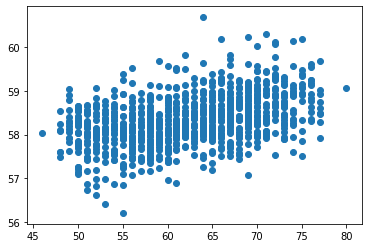

In [21]:
plt.scatter(df["test_age_1"],df["test_brainage_1"])